# ECS269U/P - Coursework, Task Description


* The **goal** of the CW is similar to that of Week 2's Lab: fitting a curve to data, also known as **curve fitting**. 
* This has applications in many different disciplines that make use of AI: FinTech, Physics Modelling, or even Sports. 
* For example, we might be interested in learning the evolution (over time) of the price of a specific product in different countries. This can depend on several factors: the product itself, the country, the initial value of the product's price, etc. 
* As usual, we are interested in learning a model that finds these relationships *from the data*. 


### The Learning Goal

* Because we are dealing with a family of functions and not just a single function, our model must be able to perform two tasks: *Function Selection* and *Regression*.
* Function selection means that given some *additional* input (to be defined below) the model somehow must choose which function $f_a$ from the family of functions $\{f_a\}$ it needs to model.
* Once the correct function is picked then the model must perform regression i.e. learn the relationship $y=f_a(x)$.



### Learning a family of functions

* The main difference with Week 2's Lab is that we will train a network that does not learn a single function but a *family of functions*.
* We will consider a family of sinusoidal functions. 
* Below you can find the code generating the data according to different random sinusoidal functions $\{f_a\}$. We randomly generate a set of 40 points in the x-axis in the interval $[-2, 2]$, slightly randomly shifted. Our functions will have the form of $y = f_a(x) = a * sin(x+a)$ where each $a$ will be randomly sampled for each function from interval $[-2, 2]$.  To "draw" a function $f_a$, we first choose some $a \sim U(-2,2)$ and then we compute $f_a$ using the above formula for all the $x$ in the x-axis. 


### The Learning Objective

* During training we randomly sample functions from the family of functions $\{f_a\}$. For each $f_a$, we are provided with the (input, output) pairs $(x_t, y_t), t=1,\dots,N_{pts}$.

* To perform *Function Selection*, a **random subset** of $(x_t, y_t), t=1,\dots,N_{pts}$ is provided as auxiliary input to the model during *both training and testing*. These auxiliary data is called the *context data:* $(x_c, y_c), c=1,\dots,N_c$. 

* Note that the total number of context points $N_c$ should be different (and randomly chosen) for every batch so that the model learns to handle different number of context points at test time. This means that the model should be able to work for e.g. $N_c=5$ but also for $N_c=12$ etc.

* Our model will take the context pairs $(x_c, y_c)$ and input values $x_t$ and will produce the estimated values $\hat{y}_t$. 

* During training we have access to the ground-truth values $y_t$, and thus we can compute a loss between the model's predictions $\hat{y}_t$ and the ground-truth values $y_t$.  


### The Model

* Our model will consists of 2 MLPs which must be jointly trained.
* The first MLP is called the *Context Encoder* or Encoder. The Encoder will take as input each pair $(x_c, y_c)$ and will produce a corresponding feature representation $r_c$ of dimension $r_{dim}$.
* A total context feature is produced by averaging over all features: $r_C= \frac{1}{N}\sum_c r_c$.
* The second MLP is called the Decoder. It takes as input the $r_C$ and each input data $x_t$ and produces the model's prediction $\hat{y}_t$. 



### Architectures

* The Encoder and the Decoder are **MLPs**. You can experiment with your own architectures. You can also choose to implement the following architectures:
* *Encoder*: It will map the input pair $(x_c, y_c)$ to some features of dimension $h_{dim}$ using 2 *hidden* layers. A final layer will produce the feature representation $r_c$ of dimension $r_{dim}$.
* *Decoder*: It will map the input pair $(r_C, x_t)$ to some features of dimension $h_{dim}$ using 2 *hidden* layers. A final layer will produce the model's prediction $\hat{y}_t$.

### Tasks

* You have to implement the following:
    1. Create the training dataset and dataloader (10%). 
    2. Create the Encoder and Decoder (20 + 20%). 
    3. Create the optimizer and the loss for your model (10%).
    4. Write the training script that will train the model and print the training loss (30%).
    5. Evaluate the model on some validation data. Plot some predictions. (10%). 

* You might want to explore the impact of the following design choices and hyperparameters:
1. Number of hidden layers and $h_{dim}$, and  $r_{dim}$.
1. Type of optimizer, batch-size and all relevant hyper-parameters from Week 5.

# Implementation

### Preparing work environment, and importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) #mount google drive

Mounted at /content/gdrive


In [ ]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils import data
import random
import torch.nn.functional as F
import numpy as np

### Task 1, Create the training dataset and dataloader (10%)

In [ ]:
Nf = 2000 # the number of different functions f that we will generate
Npts = 40 # the number of X values that we will use to generate each fa
X = torch.zeros(Nf, Npts, 1)

for k in range(Nf):
    X[k,:,0] = torch.linspace(-2, 2, Npts)

X += torch.rand_like(X)*0.1
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)
y = a*torch.sin(X+a)

In [ ]:
n_train = 2000
dataset = data.TensorDataset(X[:n_train, :, 0], y[:n_train, :, 0]) #TensorDataset object
print(dataset[0]) #First example in our dataset
batch_size = 128
data_iter =  data.DataLoader(dataset, batch_size, shuffle=True) #DataLoader object

(tensor([-1.9775, -1.8154, -1.7363, -1.6450, -1.4940, -1.4620, -1.3222, -1.2036,
        -1.1312, -1.0290, -0.9652, -0.7863, -0.7520, -0.6262, -0.5009, -0.4043,
        -0.3142, -0.1963, -0.1117, -0.0338,  0.0918,  0.1782,  0.3402,  0.4468,
         0.5056,  0.5841,  0.7423,  0.8581,  0.9457,  1.0337,  1.0894,  1.1887,
         1.3743,  1.4251,  1.5136,  1.6012,  1.7562,  1.8044,  1.9294,  2.0959]), tensor([-0.3386, -0.0510,  0.0903,  0.2527,  0.5160,  0.5705,  0.8008,  0.9842,
         1.0896,  1.2283,  1.3086,  1.5043,  1.5365,  1.6388,  1.7150,  1.7554,
         1.7783,  1.7866,  1.7772,  1.7573,  1.7029,  1.6498,  1.5175,  1.4085,
         1.3414,  1.2447,  1.0271,  0.8513,  0.7106,  0.5638,  0.4685,  0.2952,
        -0.0350, -0.1257, -0.2828, -0.4361, -0.6983, -0.7768, -0.9714, -1.2065]))


### Task 2, Create the Encoder and Decoder (20 + 20%)

In [ ]:
class Encoder(torch.nn.Module):

    def __init__(self, num_inputs, num_hidden, r_dim): 
        super(Encoder, self).__init__()
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.r_dim = r_dim

        self.Linear1 = nn.Linear(num_inputs, num_hidden)
        self.Linear2 = nn.Linear(num_hidden, num_hidden)
        self.Linear3 = nn.Linear(num_hidden, num_hidden)
        self.Linear4 = nn.Linear(num_hidden, r_dim)
        self.ReLU = nn.ReLU()
        
    def forward(self, x):
        out = self.Linear1(x)
        out = self.ReLU(out)
        out = self.Linear2(out)
        out = self.ReLU(out)
        out = self.Linear3(out)
        out = self.ReLU(out)
        out = self.Linear4(out)
        return out

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super(Decoder, self).__init__()
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs

        self.Linear1 = nn.Linear(num_inputs, num_hidden)
        self.Linear2 = nn.Linear(num_hidden, num_hidden)
        self.Linear3 = nn.Linear(num_hidden, num_hidden)
        self.Linear4 = nn.Linear(num_hidden, num_outputs)
        self.ReLU = nn.ReLU()
        
    def forward(self, x):
        out = self.Linear1(x)
        out = self.ReLU(out)
        out = self.Linear2(out)
        out = self.ReLU(out)
        out = self.Linear3(out)
        out = self.ReLU(out)
        out = self.Linear4(out)
        return out

In [ ]:
# Creating and initializing ENCODER:
num_inputs, num_hidden, r_dim = 2, 256, 30 
encoder = Encoder(num_inputs, num_hidden, r_dim)

# Creating and initializing DECODER:
num_inputs, num_hidden, num_outputs = (r_dim+40), 256, 40 
decoder = Decoder(num_inputs, num_hidden, num_outputs)

### Task 3, Create the optimizer and the loss for your model (10%)

In [ ]:
loss = nn.MSELoss()
lr = 0.01
opt_enc = torch.optim.Adam(encoder.parameters(), lr)
opt_dec = torch.optim.Adam(decoder.parameters(), lr)

### Task 4, Write the training script that will train the model and print the training loss (30%)

In [ ]:
def train(encoder, decoder, train_iter, loss, opt_enc, opt_dec, epochs):

    loss_list = []

    for epoch in range(epochs):
        for b_X, b_y in train_iter:                 # X and y extracted from train_iter, both of size (128, 40)


            
            # Extracting context pairs
            Nc = random.randint(3,35)
            context_indeces = np.random.choice(40, Nc, replace=False)
            X_c = b_X[:, context_indeces]
            y_c = b_y[:, context_indeces]
            context_pairs = torch.dstack((X_c,y_c)) # Stacking in depth dimension, yielding batches of size (128 * Nc * 2)

            #Setting gradients to zero
            opt_enc.zero_grad()
            opt_dec.zero_grad()

            r_c = encoder(context_pairs)            # Passing context pairs through ENCODER, yielding batches of size (128 * Nc * r_dim)
            r_C = torch.mean(r_c, 1)                # Averaging 'r_c's for all context pairs across each function, yielding batches of size (128 * r_dim)         
            


            dec_input = torch.cat((r_C, b_X), 1)    # Concatenating average feature representation with X-values, yielding batches of size (128 * (r_dim+40)) 
            
            
            
            y_hat = decoder(dec_input)              # Passing the concatenated data through the DECODER, yielding batches of size (128 * 40)

            l = loss(y_hat, b_y)                   
            l.backward()                            # Working with mini-batches, the gradient will be averaged across all gradients calculated in a batch

            opt_enc.step()                          # Weights are updated for ENCODER
            opt_dec.step()                          # Weights are updated for DECODER
        
        loss_list.append(l)                         # Appending loss to a list, for plotting purposes
        print(f'epoch {epoch + 1}, ',
              f'loss: {l:.4f}')


    epochs_list = np.arange(1,epochs + 1)

    plt.figure(figsize=(12,8))
    plt.plot(epochs_list, loss_list)
    plt.title('Training loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper right')
    plt.grid(True)

    plt.xlim(0,epochs)
    plt.show()

In [ ]:
epochs = 100
train(encoder, decoder, data_iter, loss, opt_enc, opt_dec, epochs)

b_x shape --> torch.Size([128, 40])
b_y shape --> torch.Size([128, 40])
b_x shape --> torch.Size([128, 40])
b_y shape --> torch.Size([128, 40])
b_x shape --> torch.Size([128, 40])
b_y shape --> torch.Size([128, 40])
b_x shape --> torch.Size([128, 40])
b_y shape --> torch.Size([128, 40])
b_x shape --> torch.Size([128, 40])
b_y shape --> torch.Size([128, 40])
b_x shape --> torch.Size([128, 40])
b_y shape --> torch.Size([128, 40])
b_x shape --> torch.Size([128, 40])
b_y shape --> torch.Size([128, 40])
b_x shape --> torch.Size([128, 40])
b_y shape --> torch.Size([128, 40])
b_x shape --> torch.Size([128, 40])
b_y shape --> torch.Size([128, 40])
b_x shape --> torch.Size([128, 40])
b_y shape --> torch.Size([128, 40])
b_x shape --> torch.Size([128, 40])
b_y shape --> torch.Size([128, 40])
b_x shape --> torch.Size([128, 40])
b_y shape --> torch.Size([128, 40])
b_x shape --> torch.Size([128, 40])
b_y shape --> torch.Size([128, 40])
b_x shape --> torch.Size([128, 40])
b_y shape --> torch.Size([12

KeyboardInterrupt: ignored

### Task 5, Evaluate the model on some validation data. Plot some predictions (10%)

In [ ]:
Nf = 6 # the number of different functions f that we will generate
Npts = 40 # the number of X values that we will use to generate each fa
test_X = torch.zeros(Nf, Npts, 1)

for k in range(Nf):
    test_X[k,:,0] = torch.linspace(-2, 2, Npts)

test_X += torch.rand_like(test_X)*0.1
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)
test_y = a*torch.sin(test_X+a)

In [ ]:
test_X = torch.squeeze(test_X)
test_y = torch.squeeze(test_y)

Nc = random.randint(3,35)
context_indeces = np.random.choice(40, Nc, replace=False)
test_X_c = test_X[:, context_indeces]
test_y_c = test_y[:, context_indeces]
context_pairs = torch.dstack((test_X_c,test_y_c))

r_c = encoder(context_pairs)
r_C = torch.mean(r_c, 1)

dec_input = torch.cat((r_C, test_X), 1)
y_hat = decoder(dec_input) #Output will be (16 * 40)

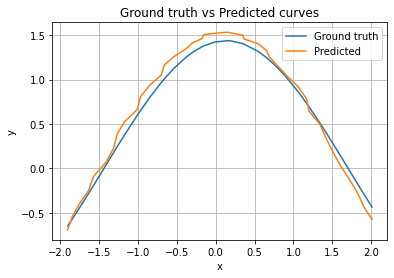

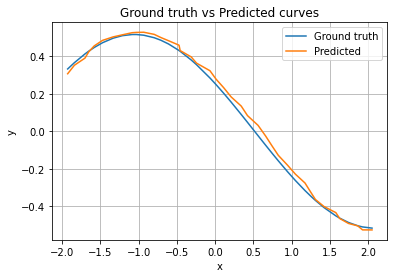

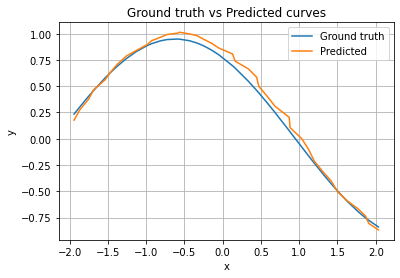

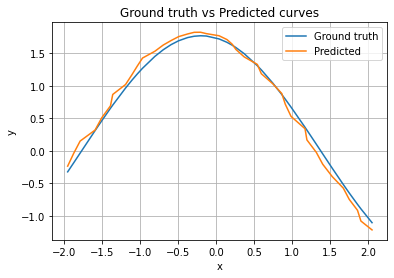

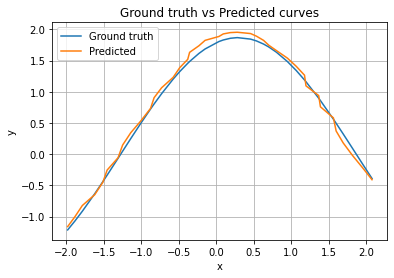

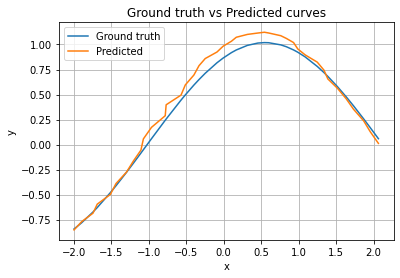

In [ ]:
for i in range(Nf):
  plt.figure()
  plt.plot(test_X[i], test_y[i])
  plt.plot(test_X[i].detach().numpy(), y_hat[i].detach().numpy())

  plt.title('Ground truth vs Predicted curves')
  plt.ylabel('y')
  plt.xlabel('x')
  plt.legend(['Ground truth', 'Predicted'])
  plt.grid(True)
  plt.show()

#### Training function with validation loss 

In [ ]:
val_X = X[n_train:len(X), :, 0] 
val_y = y[n_train:len(y), :, 0]

In [ ]:
def train(encoder, decoder, train_iter, loss, opt_enc, opt_dec, epochs):

    loss_list = []
    val_loss_list = []

    for epoch in range(epochs):
        for b_X, b_y in train_iter: #Each X and y extracted from train_iter are batches of 16

            # Extracting Nc context pairs and with zeros between context points, yielding tensors of length 40
            Nc = random.randint(3,35)
            context_indeces = np.random.choice(40, Nc, replace=False)
            X_c = b_X[:, context_indeces]
            y_c = b_y[:, context_indeces]
            context_pairs = torch.dstack((X_c,y_c)) #Now of dimension (16 * Nc * 2)

            #Setting gradients to zero
            opt_enc.zero_grad()
            opt_dec.zero_grad()

            #Predicting with batch of context data, yielding a (16 * Nc * 5) tensor  
            r_c = encoder(context_pairs)
            r_C = torch.mean(r_c, 1)

            dec_input = torch.cat((r_C, b_X), 1)
            y_hat = decoder(dec_input) #Output will be (16 * 40)

            l = loss(y_hat, b_y)
            l.backward()

            opt_enc.step()
            opt_dec.step()
        
        loss_list.append(l)

        #Making validation loss prediction
        Nc = random.randint(3,35)
        context_indeces = np.random.choice(40, Nc, replace=False)
        val_X_c = val_X[:, context_indeces]
        val_y_c = val_y[:, context_indeces]
        context_pairs = torch.dstack((val_X_c,val_y_c))

        r_c = encoder(context_pairs)
        r_C = torch.mean(r_c, 1)

        dec_input = torch.cat((r_C, val_X), 1)
        y_hat = decoder(dec_input) #Output will be (400 * 40)

        val_loss = loss(y_hat, val_y)
        val_loss_list.append(val_loss)

        print(f'epoch {epoch + 1}, ', f'loss: {l:.4f}', f'validation loss: {val_loss:.4f}')


    epochs_list = np.arange(1,epochs + 1)

    plt.figure(figsize=(12,8))
    plt.plot(epochs_list, loss_list)
    plt.plot(epochs_list, val_loss_list)
    plt.title('Training loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.grid(True)

    # plt.ylim(0., 0.2)
    plt.xlim(0,epochs)
    plt.show()

# Test data  

* Test data are stored in a dictionary where each key has the data for a single function $f_a$. We have generated 6 different functions named as `function_num_1`, `function_num_2` and so on. 

In [ ]:
import pickle
path_to_the_pickle = '/content/gdrive/MyDrive/Colab Notebooks/test_data.pkl'
test_data =pickle.load(open(path_to_the_pickle,'rb'))
# 6 test functions
i = 2 # i=1,..6
name= 'function_num_{}'.format(i)
x_c=test_data[name]['context_pairs'][0]
y_c=test_data[name]['context_pairs'][1]
x_t =test_data[name]['x']